In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [2]:
load_path='D:/VA/onehandtwohand/128/105words_DSLR_results_FH/'
CATEGORIES=np.load(load_path+'cat_105.npy', allow_pickle=True)
IMG_SIZE=128
cat_len=len(CATEGORIES)
print(cat_len)
X=np.load(load_path+'X.npy', allow_pickle=True)
Y=np.load(load_path+'Y.npy', allow_pickle=True)
# X = X.astype('float32')
# X /= 255

105


In [3]:
Y_new=[]
for i in range(len(X)):
    index = (Y[i].tolist()).index(1)
    Y_new.append(index)
len(Y_new)

Y=np.array(Y_new)
print(Y.shape)

(43450,)


In [4]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")
del X,Y

Splitting
pass


In [16]:
num_classes = cat_len
input_shape = (IMG_SIZE, IMG_SIZE, 3)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [17]:
# print('Image Data Augmentation')
# from keras.preprocessing.image import ImageDataGenerator
# val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
#     height_shift_range=0.2, shear_range=0.2, resize=(image_size, image_size,3))
# #                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
# val_generator.fit(X_train)
# val_generator.fit(X_new)
# val_generator.fit(X_test)

# print("done")

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [20]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


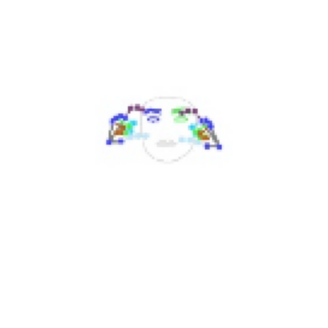

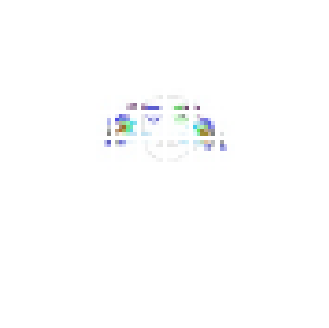

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [22]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [23]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [24]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = load_path+"tmp"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
86/86 [==============================] - 680s 8s/step - loss: 4.8991 - accuracy: 0.0159 - top-5-accuracy: 0.0707 - val_loss: 4.5219 - val_accuracy: 0.0666 - val_top-5-accuracy: 0.1906
Epoch 2/50
86/86 [==============================] - 673s 8s/step - loss: 4.4642 - accuracy: 0.0334 - top-5-accuracy: 0.1260 - val_loss: 4.0663 - val_accuracy: 0.1343 - val_top-5-accuracy: 0.3698
Epoch 3/50
86/86 [==============================] - 671s 8s/step - loss: 4.0402 - accuracy: 0.0756 - top-5-accuracy: 0.2404 - val_loss: 3.4047 - val_accuracy: 0.2490 - val_top-5-accuracy: 0.5460
Epoch 4/50
86/86 [==============================] - 670s 8s/step - loss: 3.5933 - accuracy: 0.1289 - top-5-accuracy: 0.3702 - val_loss: 2.8605 - val_accuracy: 0.3422 - val_top-5-accuracy: 0.6532
Epoch 5/50
86/86 [==============================] - 672s 8s/step - loss: 3.2241 - accuracy: 0.1861 - top-5-accuracy: 0.4718 - val_loss: 2.5109 - val_accuracy: 0.4281 - val_top-5-accuracy: 0.7391
Epoch 6/50
86/86 [=======

86/86 [==============================] - 680s 8s/step - loss: 1.0148 - accuracy: 0.6819 - top-5-accuracy: 0.9451 - val_loss: 0.6645 - val_accuracy: 0.7987 - val_top-5-accuracy: 0.9712
Epoch 26/50
86/86 [==============================] - 690s 8s/step - loss: 0.9632 - accuracy: 0.7009 - top-5-accuracy: 0.9503 - val_loss: 0.6414 - val_accuracy: 0.8106 - val_top-5-accuracy: 0.9741
Epoch 27/50
86/86 [==============================] - 686s 8s/step - loss: 0.9060 - accuracy: 0.7150 - top-5-accuracy: 0.9555 - val_loss: 0.6457 - val_accuracy: 0.8065 - val_top-5-accuracy: 0.9758
Epoch 28/50
86/86 [==============================] - 703s 8s/step - loss: 0.8794 - accuracy: 0.7240 - top-5-accuracy: 0.9586 - val_loss: 0.5835 - val_accuracy: 0.8172 - val_top-5-accuracy: 0.9803
Epoch 29/50
86/86 [==============================] - 710s 8s/step - loss: 0.8334 - accuracy: 0.7381 - top-5-accuracy: 0.9636 - val_loss: 0.5823 - val_accuracy: 0.8229 - val_top-5-accuracy: 0.9815
Epoch 30/50
86/86 [=============

In [26]:
print('Saving')
np.save(load_path+'_history.npy',history.history)
# model.save(load_path+'_model.h5') 
print("saved")

Saving
saved


In [27]:
vit_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_2[0][0]']                
                                                                                                  
 patches_3 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 144, 64)     16192       ['patches_3[0][0]']        

                                                                                                  
 multi_head_attention_11 (Multi  (None, 144, 64)     66368       ['layer_normalization_23[0][0]', 
 HeadAttention)                                                   'layer_normalization_23[0][0]'] 
                                                                                                  
 add_22 (Add)                   (None, 144, 64)      0           ['multi_head_attention_11[0][0]',
                                                                  'add_21[0][0]']                 
                                                                                                  
 layer_normalization_24 (LayerN  (None, 144, 64)     128         ['add_22[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_27 

 dense_34 (Dense)               (None, 144, 64)      8256        ['dropout_31[0][0]']             
                                                                                                  
 dropout_32 (Dropout)           (None, 144, 64)      0           ['dense_34[0][0]']               
                                                                                                  
 add_29 (Add)                   (None, 144, 64)      0           ['dropout_32[0][0]',             
                                                                  'add_28[0][0]']                 
                                                                                                  
 layer_normalization_31 (LayerN  (None, 144, 64)     128         ['add_29[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_hea